In [4]:
import os

import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.animation as manimation

import gym_env
# from LinearRL import LinearRL
from utils import create_mapping, get_transition_matrix, make_plots, record_trajectory, test_agent

In [6]:
class LinearRL:
    def __init__(self, env_name, alpha=0.1, gamma=0.904, _lambda=1.0, epsilon=0.4, num_steps=25000, policy="random"):
        self.env = gym.make(env_name)
        self.start_loc = self.env.unwrapped.start_loc
        self.target_loc = self.env.unwrapped.target_loc
        self.maze = self.env.unwrapped.maze
        self.size = self.maze.size
        self.height, self.width = self.maze.shape
        self.target_locs = [self.target_loc]
        self.mapping = create_mapping(self.maze)
        self.T, self.barriers = get_transition_matrix(self.env, self.size, self.mapping)
        

        # Get terminal states
        self.terminals = np.diag(self.T) == 1
        # Calculate P = T_{NT}
        self.P = self.T[~self.terminals][:,self.terminals]
        # self.P = self.T[:, self.terminals]
        # Calculate reward
        self.r = np.full(len(self.T), -0.1)     # our reward at each non-terminal state to be -1
        self.r[self.terminals] = 1           # reward at terminal state is 0
        self.expr_t = np.exp(self.r[self.terminals] / _lambda)      # exp(r) = exp(-c) at terminal state
        self.expr_nt = np.exp(-0.1/_lambda)     # exp(r) = exp(-c) at non-terminal states

        # Params
        self.alpha = alpha
        self.gamma = self.expr_nt
        self._lambda = _lambda
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.policy = policy

        # Model
        self.DR = self.get_DR()
        self.Z = np.full(self.size, 0.01)

        self.V = np.zeros(self.size)
        self.one_hot = np.eye(self.size)

    def get_DR(self):
        if self.policy == "random":
            DR = np.eye(self.size)
        
        elif self.policy == "softmax":
            DR = np.full((self.size, self.size), 0.01)
            DR[:, self.barriers] = 0
            DR[self.barriers, :] = 0
            np.fill_diagonal(DR, 1)

        return DR

    def update_V(self):
        self.Z[~self.terminals] = self.DR[~self.terminals][:,~self.terminals] @ self.P @ self.expr_t
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)
    
    def importance_sampling(self, state, s_prob):
        successor_states = self.env.unwrapped.get_successor_states(state)
        p = 1/len(successor_states)
        w = p/s_prob
                
        return w

    def select_action(self, state, beta=5, target_loc=None):
        if self.policy == "random":
            return self.env.unwrapped.random_action()
        
        elif self.policy == "softmax":
            successor_states = self.env.unwrapped.get_successor_states(state)      # succesor_states = [(state, terminated), ...]
            action_probs = np.full(self.env.action_space.n, 0.0)

            v_sum = sum(
                        np.exp((np.log(self.Z[self.mapping[(s[0][0],s[0][1])]] + 1e-20)) / beta) for s in successor_states
                        )

            # if we don't have enough info, random action
            if v_sum == 0:
                return self.env.unwrapped.random_action() 

            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction
                
                action_probs[action] = np.exp((np.log(self.Z[self.mapping[(new_state[0], new_state[1])]] + 1e-20)) / beta ) / v_sum

            action = np.random.choice(self.env.action_space.n, p=action_probs)
            s_prob = action_probs[action]

            return action, s_prob
    
        elif self.policy == "egreedy":
            if np.random.uniform(low=0, high=1) < self.epsilon:
                return self.env.unwrapped.random_action()
            else:
                action_values = np.full(self.env.action_space.n, -np.inf)
                for action in self.env.unwrapped.get_available_actions(state):
                    direction = self.env.unwrapped._action_to_direction[action]
                    new_state = state + direction

                    if self.maze[new_state[0], new_state[1]] == "1":
                        continue

                    action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

                return np.argmax(action_values)
            
        elif self.policy == "test":
            action_values = np.full(self.env.action_space.n, -np.inf)
            for action in self.env.unwrapped.get_available_actions(state):
                direction = self.env.unwrapped._action_to_direction[action]
                new_state = state + direction

                # Need this to make it work for now
                if np.array_equal(new_state, target_loc):
                    return action

                if self.maze[new_state[0], new_state[1]] == "1":
                    continue
                action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)

            return np.nanargmax(action_values)

    def get_D_inv(self):
        # New way of doing it
        I = np.eye(self.size)
        D_inv = np.linalg.inv(I-self.gamma*self.T)

        return D_inv

    def learn(self):
        """
        Agent randomly explores the maze and and updates its DR as it goes
        """
        print(f"Decision Policy: {self.policy}")
        self.env.reset()

        # Iterate through number of steps
        for i in range(self.num_steps):
            # Current state
            state = self.env.unwrapped.agent_loc
            state_idx = self.mapping[(state[0], state[1])]

            # Choose action
            if self.policy == "softmax":
                action, s_prob = self.select_action(state, self.policy)
            else:
                action = self.select_action(state, self.policy)

            # Take action
            obs, _, done, _, _ = self.env.step(action)

            # Unpack observation to get new state
            next_state = obs["agent"]
            next_state_idx = self.mapping[(next_state[0], next_state[1])]

            # Importance sampling
            if self.policy == "softmax":
                w = self.importance_sampling(state, s_prob)
                w = 1 if np.isnan(w) or w == 0 else w
            else:
                w = 1
            
            ## Update default representation
            TDE =  self.one_hot[state_idx] + self.gamma * self.DR[next_state_idx]
            self.DR[state_idx] = (1 - self.alpha) * self.DR[state_idx] + self.alpha * TDE * w

            ## Update Z-Values
            self.Z = self.DR[:,~self.terminals] @ self.P @ self.expr_t

            # Update state
            if done:
                self.env.reset()
                continue
            state = next_state
            
        
        self.Z[self.terminals] = np.exp(self.r[self.terminals] / self._lambda)
        self.V = np.round(np.log(self.Z), 2)

In [7]:
agent = LinearRL(env_name="tolman-10x10-latent", _lambda=1.0, alpha=0.01, num_steps=400000, policy="random")

In [8]:
# agent.maze

In [9]:
# Run learning on non-blocked detour environment
agent.learn()

Decision Policy: random


/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:210: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/dx/6bb4vg5j0r9cwkqygrg_kqkm0000gn/T/ipykernel_68167/3084750285.py:178: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)


In [10]:
print(agent.V.reshape((agent.height, agent.width)))

[[  -inf  -8.28   -inf   -inf  -6.83   -inf   -inf  -0.14   0.19   0.55]
 [ -8.36  -8.16  -7.63  -7.09  -6.72  -6.67   -inf  -0.11   0.39   1.  ]
 [ -8.37  -8.15  -7.38  -6.75  -6.12  -6.5    -inf  -0.62   -inf   -inf]
 [  -inf  -8.66   -inf   -inf  -5.16   -inf   -inf  -1.21   -inf   -inf]
 [  -inf  -9.14   -inf   -inf  -4.42  -3.67  -2.91  -2.11   -inf   -inf]
 [  -inf  -9.63   -inf  -5.1   -4.63  -3.9   -3.31  -2.89   -inf   -inf]
 [  -inf -10.17   -inf  -5.41  -5.22   -inf   -inf  -3.52   -inf   -inf]
 [-11.21 -10.88   -inf  -5.7   -5.7    -inf  -4.73  -4.31   -inf   -inf]
 [-11.4  -11.33   -inf   -inf  -6.07   -inf  -5.07  -5.25  -5.77  -6.18]
 [  -inf -11.46   -inf   -inf  -6.23   -inf   -inf  -5.66  -6.04  -6.28]]


In [11]:
D_inv = agent.get_D_inv()
# agent.DR = D_inv
# agent.update_V()
# agent.V.reshape((agent.height, agent.width))
print(D_inv.reshape((agent.height, agent.width)))

ValueError: cannot reshape array of size 10000 into shape (10,10)

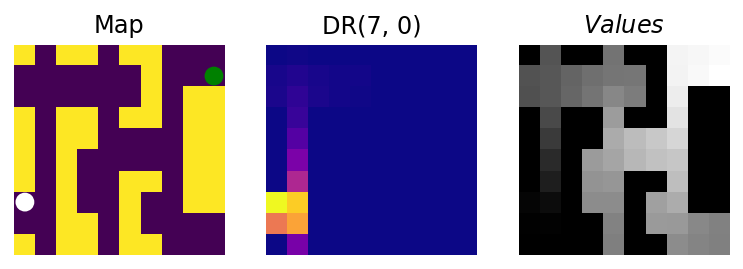

In [ ]:
make_plots(agent)

In [27]:
print(f"Start location: {agent.start_loc}, Target location: {agent.target_loc}")
traj_old_goal = test_agent(agent)

Start location: [7 0], Target location: [1 9]
Starting in state: [7 0]
Took action: 1 and arrived in state: [7 1]
Took action: 2 and arrived in state: [6 1]
Took action: 2 and arrived in state: [5 1]
Took action: 2 and arrived in state: [4 1]
Took action: 2 and arrived in state: [3 1]
Took action: 2 and arrived in state: [2 1]
Took action: 1 and arrived in state: [2 2]
Took action: 1 and arrived in state: [2 3]
Took action: 1 and arrived in state: [2 4]
Took action: 0 and arrived in state: [3 4]
Took action: 0 and arrived in state: [4 4]
Took action: 1 and arrived in state: [4 5]
Took action: 1 and arrived in state: [4 6]
Took action: 1 and arrived in state: [4 7]
Took action: 2 and arrived in state: [3 7]
Took action: 2 and arrived in state: [2 7]
Took action: 2 and arrived in state: [1 7]
Took action: 1 and arrived in state: [1 8]
Took action: 1 and arrived in state: [1 9]
Took 19 steps


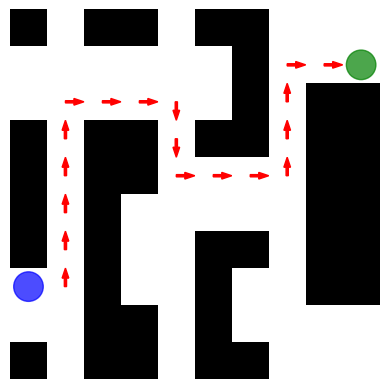

In [28]:
record_trajectory(agent, traj_old_goal)

## New Goal

In [43]:
# Get new maze and initialize a new agent
new_agent = LinearRL(env_name="tolman-10x10-latent-new-goal", _lambda=1.0, alpha=0.01)

In [44]:
# D_inv = new_agent.get_D_inv()
# new_agent.DR = D_inv
# new_agent.update_V()
# new_agent.V.reshape((new_agent.height, new_agent.width))

In [45]:
new_agent.target_loc

array([9, 9])

In [46]:
# New goal location
loc = new_agent.target_loc
idx = agent.mapping[(loc[0], loc[1])]

In [47]:
idx

99

In [48]:
L0 = np.diag(np.exp(-agent.r)) - agent.T
L = np.diag(np.exp(-agent.r)) - new_agent.T

D0 = D_inv
# D0 = agent.DR

idx = agent.mapping[(loc[0], loc[1])]

d = L[idx, :] - L0[idx, :]
m0 = D0[:,idx]

# Convert d to a row vector of size (1, m)
d = d.reshape(1, -1)

# Convert m0 to a column vector of size (m, 1)
m0 = m0.reshape(-1, 1)

# Get the amount of change to the DR
alpha = (np.dot(m0,d)) / (1 + (np.dot(d,m0)))
change = np.dot(alpha,D0)

# Apply change to DR
D = np.copy(D0)
D -= change

In [49]:
D_inv_new = new_agent.get_D_inv()
# new_agent.DR = D_inv
new_agent.DR = D
new_agent.update_V()
new_agent.V.reshape((agent.height, agent.width))

/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_28079/2454964959.py:55: RuntimeWarning: divide by zero encountered in log
  self.V = np.round(np.log(self.Z), 2)
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_28079/2454964959.py:55: RuntimeWarning: invalid value encountered in log
  self.V = np.round(np.log(self.Z), 2)


array([[  -inf, -42.16,   -inf,   -inf,    nan,   -inf,   -inf, -38.73,
        -38.34, -38.15],
       [-44.51, -43.23, -44.58,    nan, -41.48, -41.14,   -inf, -38.49,
        -38.46, -37.81],
       [   nan,    nan,    nan,    nan,    nan,    nan,   -inf,    nan,
          -inf,   -inf],
       [  -inf, -42.81,   -inf,   -inf, -41.33,   -inf,   -inf, -37.7 ,
          -inf,   -inf],
       [  -inf,    nan,   -inf,   -inf, -38.52, -38.93, -39.08, -37.54,
          -inf,   -inf],
       [  -inf, -43.37,   -inf, -39.34, -39.3 ,    nan,    nan, -37.55,
          -inf,   -inf],
       [  -inf,    nan,   -inf, -42.52,    nan,   -inf,   -inf,    nan,
          -inf,   -inf],
       [   nan,    nan,   -inf, -40.25, -40.45,   -inf, -35.52, -34.64,
          -inf,   -inf],
       [   nan,    nan,   -inf,   -inf,    nan,   -inf,    nan, -34.13,
        -34.27,    nan],
       [  -inf, -47.59,   -inf,   -inf, -39.94,   -inf,   -inf,    nan,
        -33.55,   1.  ]])

In [50]:
new_agent_traj = test_agent(new_agent)

/Users/abizzle/anaconda3/envs/gym/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
/var/folders/sf/4_xlxj4j2r1_sx5v07843wbw0000gn/T/ipykernel_28079/2454964959.py:119: RuntimeWarning: invalid value encountered in log
  action_values[action] = round(np.log(self.Z[self.mapping[(new_state[0],new_state[1])]]), 2)


Starting in state: [7 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in state: [8 0]
Took action: 0 and arrived in

KeyboardInterrupt: 

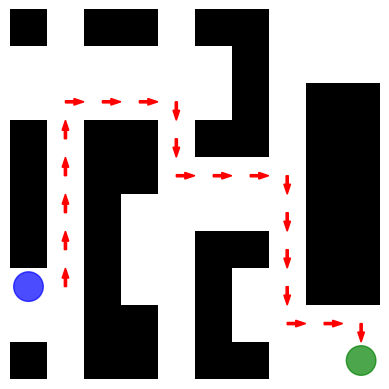

In [38]:
record_trajectory(new_agent, new_agent_traj)

## Find Absolute Difference

In [39]:
print(F"Difference between Updated D (using D_TD) and D_inv of new environemnt: {np.max(np.abs(D - D_inv_new))}")

Difference between Updated D (using D_TD) and D_inv of new environemnt: 4.928749500979022


In [ ]:
print(F"Difference between Updated D (using D_inv) and D_inv of new environemnt: {np.max(np.abs(D - D_inv_new))}")